# **Hate Speech Detector using R-NN**

**Shayling Zhao**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Reading in CSV file using pandas and converting author column to categorical data. Displaying first few rows and counts by author:**


In [2]:
data = pd.read_csv("hatespeech.csv") # Read in csv file
data["label"] = data["label"].astype('category') # Convert to category
data["text"] = data["text"].astype('string') # Convert text to string
print(data.dtypes) # Check data types
data.head() # Print first few rows
print("\n")
print(data.head()) # Printing first few lines of file
print("\n")
count = data['label'].value_counts() # Running count of type freqency
print('Frequency of Hate Speech (1) and No Hate Speech (0):\n\n', count) 

corpus = data["text"].str.lower()

Unnamed: 0       int64
text            string
label         category
dtype: object


   Unnamed: 0                                               text label
0           0  It should be legal for a husband to rape his wife     1
1           1                            dalits are lowlife scum     1
2           2                                dalits are lowlives     1
3           3  It was a better world when women dare not ques...     1
4           4  I don't work this hard so that those immigrant...     1


Frequency of Hate Speech (1) and No Hate Speech (0):

 0    48219
1    24366
Name: label, dtype: int64


**Making sure TensorFlow 2.x is used**

In [3]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

**Preprocessing Text:**

In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
import numpy as np

In [5]:
vocab_size = 10000
embedding_dim = 64
max_length = 50

X = corpus
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, 
            test_size=0.2, train_size=0.8, random_state=1234)

# Tokenize and take most frequent 5000 words
# Replacing all words that are not recognized with "<OOV>"
tokens = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Go through all the text and fit itself to the corpus. 
tokens.fit_on_texts(X_train)
# Full list of words is available as the tokenizer's word index property
word_index = tokens.word_index

# Creating numerical sequences that represent the sentences
train_sequences = tokens.texts_to_sequences(X_train) # For training data
# Handling sentences with different lengths by adding zeros at the end
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post', truncating='post')# For training data

test_sequences = tokens.texts_to_sequences(X_test) # For testing data
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post', truncating='post') # For testing data

# (number of sequences, each with this number of tokens)
print(train_padded.shape)
print(test_padded.shape)

(58068, 50)
(14517, 50)


**Ensure it works:**



In [6]:
import numpy as np
train_padded = np.array(train_padded)
y_train = np.array(y_train)
test_padded = np.array(test_padded)
y_test = np.array(y_test)

# **Trying Recurrent Neural Networks:**

In [7]:


# Building the model:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             # First:
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



num_epochs = 5
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test), verbose=2)

Epoch 1/5
1815/1815 - 103s - loss: 0.4169 - accuracy: 0.7889 - val_loss: 0.3618 - val_accuracy: 0.8258
Epoch 2/5
1815/1815 - 97s - loss: 0.3156 - accuracy: 0.8504 - val_loss: 0.3458 - val_accuracy: 0.8329
Epoch 3/5
1815/1815 - 97s - loss: 0.2648 - accuracy: 0.8755 - val_loss: 0.3394 - val_accuracy: 0.8415
Epoch 4/5
1815/1815 - 97s - loss: 0.2276 - accuracy: 0.8942 - val_loss: 0.3639 - val_accuracy: 0.8444
Epoch 5/5
1815/1815 - 97s - loss: 0.1955 - accuracy: 0.9109 - val_loss: 0.3969 - val_accuracy: 0.8456


First - Defining we want an LSTM style layer. It takes a numeric parameter for the number of hidden nodes within it, and this is also the dimensionality of the output space from this layer. Bidirectional will look at your sentence forwards and backwards, learn the best parameters for each, and merges them. 

As you can see here, the algo starts to overfit after it goes past the 3rd epoch. Because the accuracy starts to significantly surpass the validation accuracy. The accuracy and validation accuracy shouldn't be too much different from one another. 

**Plotting the Chart:**

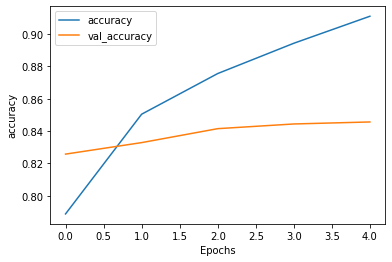

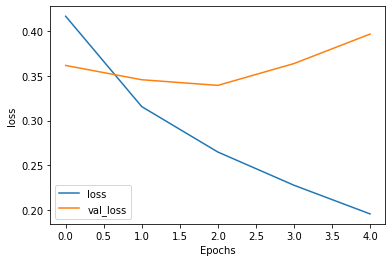

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**As you can see here, clear overfitting is happening because the val_accuracy is way lower than the accuracy. The val_accuracy refers to the "validation set". This refers to a set of samples that was not shown to the network during training and hence refers to how much your model works in general for cases outside the training set.**

# **ROC Analysis:**

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),  # can experiment with label smoothing values
                                  metrics=['binary_accuracy', 
                                           tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', name='ROC'),
                                           tf.keras.metrics.AUC(num_thresholds=200, curve='PR', name='Precision-Recall')],
                                  steps_per_execution=4)

history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test), verbose=2)

Epoch 1/5
1815/1815 - 107s - loss: 0.1397 - binary_accuracy: 0.9385 - ROC: 0.9867 - Precision-Recall: 0.9744 - val_loss: 0.4565 - val_binary_accuracy: 0.8427 - val_ROC: 0.9105 - val_Precision-Recall: 0.8403
Epoch 2/5
1815/1815 - 97s - loss: 0.1265 - binary_accuracy: 0.9450 - ROC: 0.9890 - Precision-Recall: 0.9788 - val_loss: 0.5087 - val_binary_accuracy: 0.8427 - val_ROC: 0.9067 - val_Precision-Recall: 0.8326
Epoch 3/5
1815/1815 - 97s - loss: 0.1173 - binary_accuracy: 0.9493 - ROC: 0.9905 - Precision-Recall: 0.9817 - val_loss: 0.5407 - val_binary_accuracy: 0.8421 - val_ROC: 0.9030 - val_Precision-Recall: 0.8250
Epoch 4/5
1815/1815 - 97s - loss: 0.1100 - binary_accuracy: 0.9527 - ROC: 0.9916 - Precision-Recall: 0.9836 - val_loss: 0.5545 - val_binary_accuracy: 0.8414 - val_ROC: 0.9019 - val_Precision-Recall: 0.8234
Epoch 5/5
1815/1815 - 98s - loss: 0.1031 - binary_accuracy: 0.9562 - ROC: 0.9925 - Precision-Recall: 0.9855 - val_loss: 0.6019 - val_binary_accuracy: 0.8388 - val_ROC: 0.8981 

**ROC came out to be almost 1 which is excellent!**